# Metadata

```yaml
Course:    DS 5001 
Module:    09 Lab
Topic:     Using GloVe
Author:    R.C. Alvarado
Date:      28 March 2023 (revised)
```

**Purpose:** We use some pretrained word vectors from [the developers of GloVe](https://nlp.stanford.edu/projects/glove/).

# About GloVe

> Unlike the matrix factorization methods, the shallow window-based methods [e.g. word2vec] suffer \
> from the disadvantage that **they do not operate directly on the co-occurrence statistics of the corpus.** \
> Instead, these models scan context windows across the entire corpus, which fails to take advantage of the \
> vast amount of repetition in the data.

# Set Up

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_in = f'{data_home}/glove'
# db_file = f'{data_in}/glove2.db'

In [3]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity

# Import GloVe data

We import a word embedding with 400,000 token types and 50. 100, 200, or 300 features.

In [4]:
n_features = 100 # 50, 100, 200, 300

In [5]:
glove = pd.read_csv(f"{data_in}/glove.6B/glove.6B.{n_features}d.txt", sep="\s", header=None, engine='python')
glove = glove.set_index(0)
glove.index.name = 'term_str'
glove = glove.astype(float)

FileNotFoundError: [Errno 2] No such file or directory: '/home/rca2t/Documents/MSDS/DS5001/data/glove/glove.6B/glove.6B.100d.txt'

In [ ]:
glove.shape

(400000, 100)

In [ ]:
glove.sample(10)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
term_str,,,,,,,,,,,,,,,,,,,,,
uighurs,0.522010,0.777180,0.187950,-0.967240,0.088990,0.851840,-0.738170,-0.494660,0.812750,0.583890,...,0.427600,-0.119600,-0.592370,-0.565210,-0.103990,-0.414570,-0.782410,0.303340,-0.730020,-0.404400
hyperventilation,0.316030,0.163130,0.362390,0.013921,-0.386120,0.381790,-0.417960,-0.009201,0.419480,-0.495910,...,-0.323270,0.164620,-0.391620,-0.140950,0.716100,0.135740,0.663760,0.076894,-0.125380,-0.163610
browde,0.119030,-0.226080,-1.099900,-0.407510,0.137520,-0.706170,0.585260,-0.432890,0.216020,-0.072673,...,0.278800,0.171360,0.311690,-0.071107,0.522020,-0.003680,-0.209210,0.490640,-1.019800,0.456400
daramy,0.070769,0.071062,-0.010246,0.092191,-0.070682,-0.046491,0.038852,-0.273260,0.074936,-0.224240,...,0.029732,0.134650,0.716320,0.031212,0.215160,-0.127300,0.026538,0.264990,-0.813240,0.219040
kalmia,-0.364050,-0.538890,-0.603490,0.397740,0.119810,-0.442200,-0.310030,0.363110,0.001895,-0.474930,...,-0.488550,-0.138490,0.303200,0.373730,0.310450,-0.014833,0.085263,-0.359650,-0.500360,-0.052170
chisago,-0.028768,-0.023362,0.352390,0.139670,0.652660,0.411730,-0.030460,0.681240,0.746020,-0.610640,...,0.081129,0.226750,-0.751190,-0.067396,0.015494,0.115120,-0.728240,0.648190,-0.095004,-0.051561
msfc,0.421130,-0.226920,-0.191920,0.338360,-0.282470,-0.216270,-0.382580,-0.160290,0.000183,0.153620,...,0.137960,-0.282150,0.322060,-0.550190,0.329040,0.019657,0.285450,0.638910,-0.385770,-0.225470
maitreyi,-0.041028,-0.354220,-0.719140,0.484560,-0.294360,-0.260600,0.086653,-0.161070,0.329720,0.052643,...,0.054986,0.202310,0.063636,-0.012221,-0.073001,-0.287320,0.280940,0.048024,-0.263590,0.001849
thunderer,-0.089777,-0.674710,-0.148920,-0.468510,-0.439250,-0.430560,0.001842,-0.229140,0.131950,-0.168470,...,-0.040991,-0.037068,0.175010,0.331370,0.595890,-0.291390,-0.016523,-0.079333,-0.635970,-0.096605


# Explore Features

In [ ]:
test_sentence = sorted(list(set("the quick brown fox jumped over the lazy dogs".split())))

In [ ]:
glove.loc[test_sentence].T.sample(10).T\
    .style.format(precision=2).background_gradient(cmap='YlGnBu', axis=None)

,15,37,2,84,5,39,78,1,97,31
term_str,,,,,,,,,,
brown,0.10,0.15,-0.10,-0.22,0.11,0.28,0.34,-0.44,-1.13,0.46
dogs,0.44,0.02,0.30,0.50,-0.79,0.83,0.11,0.38,-1.12,0.12
fox,0.51,-0.04,-1.00,-0.19,0.04,0.50,0.28,0.17,-0.28,0.65
jumped,0.76,-0.23,0.37,-0.32,0.50,0.67,0.19,1.63,-0.00,0.40
lazy,0.53,-0.70,-0.20,-0.01,-0.94,0.85,0.56,0.14,-0.74,0.13
over,0.24,-0.02,0.35,0.52,-0.03,-0.47,-0.02,-0.30,-0.20,-0.29
quick,0.37,-0.13,-0.22,-0.48,-0.32,0.08,-0.04,-0.43,0.21,-0.63
the,-0.13,0.20,-0.24,0.26,0.08,0.17,-0.21,-0.04,-0.52,-0.04


In [ ]:
FEATURE = glove.mean().to_frame('mean_weight')
FEATURE['max_weight'] = glove.max()
FEATURE['min_weight'] = glove.min()
FEATURE['max_word'] = glove.idxmax()
FEATURE['min_word'] = glove.idxmin()

In [ ]:
# FEATURE.sample(10)

# Are embedding features like topics?

In [ ]:
FEATURE['top_words'] = FEATURE.apply(lambda x: ' '.join(glove[x.name].sort_values(ascending=False).head(7).index), axis=1)

In [ ]:
FEATURE.sort_values('mean_weight', ascending=False).head(20)

,mean_weight,max_weight,min_weight,max_word,min_word,top_words
56,0.452438,2.4311,-3.6792,sayn,a,sayn microns djordje azarias djukic republish ...
85,0.279431,2.6886,-3.0816,chernykh,patients,chernykh elhanan mollusk kloza mcnaught coonab...
79,0.259760,2.5450,-2.3225,saute,smithee,saute mixer unsalted skillet invert reheat bro...
50,0.226047,2.2537,-2.7613,abilio,resend,abilio novaya ouvrage zille andry tassos kennet
95,0.214568,2.6155,-2.1484,ergenekon,lufkin,ergenekon bulbophyllum sql racketeering verein...
42,0.199964,2.5956,-2.8971,zabihullah,tablespoons,zabihullah ayp hizbul foday shamil bhasa asom
74,0.171391,2.9406,-2.6029,herein,ihs,herein lxii viic besets kilograms grams dragila
9,0.167588,2.7588,-2.7738,otros,unbeaten,otros paises tambien estan jaane latinoamerica...
28,0.166160,2.4583,-2.4019,cosmodrome,shuh,cosmodrome multiplexed xichang plesetsk detona...
48,0.151903,2.6423,-3.2878,passerine,republish,passerine verbandsgemeinde carbonyl birla cred...


# Remove non-words

There are a lot of useless tokens in the vocabulary. These may be good for generating the features, but we don't need them in our queries.

In [ ]:
# glove = glove.reset_index().astype(str)
# glove = glove[glove.term_str.str.match(r'^[a-z]+$')]
# glove = glove.set_index('term_str')
glove = glove[glove.index.str.match(r'^[a-z]+$')]
glove = glove.astype(float)
glove.shape

(317757, 100)

In [ ]:
# glove.index.value_counts()

In [ ]:
FEATURE['top_words2'] = FEATURE.apply(lambda x: ' '.join(glove[x.name].sort_values(ascending=False).head(7).index), axis=1)

In [ ]:
FEATURE.head(20)

,mean_weight,max_weight,min_weight,max_word,min_word,top_words,top_words2
1,0.052098,2.4396,-4.0666,bovespa,republish,bovespa 225-issue cac-40 balco knowingly zetas...,bovespa balco knowingly zetas ordinaries sugar...
2,-0.097114,2.5180,-2.3313,distillates,zhongshu,distillates distillate outnumbering expander 2...,distillates distillate outnumbering expander w...
3,-0.138076,2.6546,-2.2963,aonb,right-arm,aonb radomsko keyless text-type (310) update2 ...,aonb radomsko keyless kgalema voivodeship noct...
4,0.110753,3.2142,-2.4469,non-mandatory,porpoises,non-mandatory jonubi certiorari algebraic norm...,jonubi certiorari algebraic normalising barvik...
5,-0.027228,2.7884,-2.4436,baronetage,statesman.com,baronetage longlisted worldsources ayman olyā ...,baronetage longlisted worldsources ayman mcca ...
6,-0.003264,2.5575,-2.6252,c/d,petroleum,c/d 33-1-47-42-80-44 lycaenidae chanting canon...,lycaenidae chanting canons mobs catholic chant...
7,0.031764,2.2657,-2.4128,g6,sensex,g6 undervotes glafcos agusta lancer yearling s...,undervotes glafcos agusta lancer yearling span...
8,-0.050769,2.2472,-2.4823,weekdays,jacobite,weekdays saturdays vidhan canvassing panamá fi...,weekdays saturdays vidhan canvassing fille com...
9,0.153216,2.7588,-2.7738,otros,unbeaten,otros paises tambien estan (816) castile-la jaane,otros paises tambien estan jaane latinoamerica...
10,-0.023674,2.3914,-2.2391,hossein,uk-apc,hossein bushehr leed plesetsk warhead vung gan...,hossein bushehr leed plesetsk warhead vung gan...


# Define some semantic functions

In [ ]:
def get_word_vector(term_str):
    """Get a numpy array from the glove matrix and shape for input into cosine function"""
    wv = glove.loc[term_str].values.reshape(-1, 1).T
    return wv

def get_sims(term_str, n=10):
    """Get the top n words for a given word based on cosine similarity"""
    wv = get_word_vector(term_str)
    sims = cosine_similarity(glove.values, wv)
    return pd.DataFrame(sims, index=glove.index, columns=['score'])\
        .sort_values('score', ascending=False).head(n)

def get_nearest_vector(wv):
    """Get the nearest word vector to a given word vector"""
    sims = cosine_similarity(glove.values, wv)
    return pd.DataFrame(sims, index=glove.index, columns=['score'])\
        .sort_values('score', ascending=False).head(2).iloc[1]

def get_difference(a, b):
    try:
        A = get_word_vector(a)
        B = get_word_vector(b)
        C = np.subtract(A, B)
        X = get_nearest_vector(C)
        return X.name
    except ValueError as e:
        print(e)
        return None

def get_sum(a, b):
    try:
        A = get_word_vector(a)
        B = get_word_vector(b)
        C = np.add(A, B)
        X = get_nearest_vector(C)
        return X.name
    except ValueError as e:
        print(e)
        return None

def get_analogy(a, b, c):
    """Infer missing analogical term"""
    try:
        A = get_word_vector(a)
        B = get_word_vector(b)
        C = get_word_vector(c)
        D = np.add(np.subtract(B, A), C)
        X = get_nearest_vector(D)
        return X.name
    except ValueError as e:
        print(e)
        return None

# Test similarity function

In [ ]:
get_sims('queen')

,score
term_str,
queen,1.000000
princess,0.794724
king,0.750769
elizabeth,0.735571
royal,0.706503
lady,0.704480
victoria,0.685376
monarch,0.668326
crown,0.668056


In [ ]:
get_sims('king')

,score
term_str,
king,1.000000
prince,0.768233
queen,0.750769
son,0.702089
brother,0.698578
monarch,0.697789
throne,0.691999
kingdom,0.681141
father,0.680203


In [ ]:
get_sims('milk')

,score
term_str,
milk,1.000000
dairy,0.761276
meat,0.748176
sugar,0.734551
yogurt,0.695376
juice,0.694653
cream,0.685067
egg,0.683237
soda,0.676703


In [ ]:
get_sims('beer')

,score
term_str,
beer,1.000000
drink,0.818214
drinks,0.798284
liquor,0.732116
coffee,0.725339
vodka,0.724695
wine,0.724451
bottle,0.717643
beers,0.699328


# Test difference function

In [ ]:
get_difference('man', 'woman')

'ancelotti'

In [ ]:
get_sims('ancelotti')

,score
term_str,
ancelotti,1.000000
ranieri,0.822743
mourinho,0.820027
capello,0.736949
houllier,0.719588
mancini,0.713135
wenger,0.710990
scolari,0.690986
lippi,0.687543


In [ ]:
get_difference('woman', 'man')

'miscarry'

In [ ]:
get_sims('miscarry')

,score
term_str,
miscarry,1.000000
ovulate,0.628454
breastfeed,0.617344
menstruate,0.600057
miscarried,0.588849
mortify,0.582306
vocalize,0.580238
gestate,0.563410
ovulating,0.562108


In [ ]:
get_difference('human', 'culture')

'nonhuman'

In [ ]:
get_sims('nonhuman')

,score
term_str,
nonhuman,1.000000
primates,0.697258
habitations,0.623479
fallible,0.617184
beings,0.576165
apes,0.558138
anthropomorphic,0.552706
strepsirrhine,0.545927
vertebrates,0.538547


In [ ]:
get_difference('man', 'human')

'fireman'

In [ ]:
get_sims('fireman')

,score
term_str,
fireman,1.000000
firefighter,0.717793
paramedic,0.574579
mechanic,0.564724
rescuer,0.551241
chauffeur,0.542937
welder,0.542476
watchman,0.522622
janitor,0.515656


In [ ]:
get_difference('human', 'man')

'reproductive'

In [ ]:
get_difference('woman', 'human')

'schoolteacher'

In [ ]:
get_difference('human', 'woman')

'mechanisms'

In [ ]:
get_difference('christianity', 'jesus')

'protestantism'

In [ ]:
get_sum('protestantism', 'pope')

'catholicism'

In [ ]:
get_sims('protestantism')

,score
term_str,
protestantism,1.000000
catholicism,0.913007
christianity,0.811677
lutheranism,0.800469
calvinism,0.749115
anglicanism,0.729683
orthodoxy,0.673827
methodism,0.672810
hinduism,0.663173


# Test analogy function

## MALE / FEMALE

In [ ]:
get_analogy('dog', 'male', 'cat')

'female'

In [ ]:
get_analogy('male', 'doctor', 'female')

'nurse'

In [ ]:
get_analogy('king', 'queen', 'male')

'female'

In [ ]:
get_analogy('king', 'male', 'queen')

'female'

In [ ]:
get_analogy('queen', 'female', 'king')

'male'

In [ ]:
get_analogy('female', 'princess', 'male')

'queen'

In [ ]:
get_analogy('male', 'prince', 'female')

'king'

In [ ]:
get_analogy('male', 'father', 'female')

'brother'

In [ ]:
get_analogy('female', 'mother', 'male')

'daughter'

In [ ]:
get_analogy('woman', 'mother', 'man')

'brother'

In [ ]:
get_analogy('woman', 'man', 'female')

'male'

## LEFT / RIGHT

In [ ]:
get_analogy('right', 'male', 'left')

'female'

In [ ]:
get_analogy('right', 'left', 'male')

'female'

In [ ]:
get_analogy('right', 'man', 'left')

'dead'

In [ ]:
get_analogy('man', 'woman', 'right')

'woman'

In [ ]:
get_analogy('left', 'right', 'white')

'black'

In [ ]:
get_analogy('left', 'right', 'black')

'white'

In [ ]:
get_analogy('woman', 'man', 'left')

'back'

## OTHER

In [ ]:
get_analogy('sun','moon', 'male')

'female'

In [ ]:
get_analogy('day', 'sun', 'night')

'sky'

# Experiment

Demonstrate how to project embeddings onto documents

In [ ]:
LIB = pd.read_csv(f"{output_dir}/austen-melville-LIB_FIXED.csv").set_index('book_id')

In [ ]:
CORPUS = pd.read_csv(f"{output_dir}/austen-melville-CORPUS.csv")\
    .merge(glove, on="term_str")\
    .set_index(['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num'])\
    .iloc[:, 5:]

In [ ]:
CORPUS

1         2         3    \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0         -0.720780  0.200910 -0.048074   
                                  1         -0.113040  0.417170 -0.487840   
                                  2         -0.082324 -0.720100  0.414510   
                                  3         -0.152900 -0.242790  0.898370   
                                  5          0.500700  0.411670 -0.186850   
...                                               ...       ...       ...   
34970   114     24       0        6         -0.038194 -0.244870  0.728120   
                                  7          0.599810 -0.027188  0.622390   
                                  8         -0.208750 -0.117400  0.264780   
                                  9         -0.443600 -0.171370 -0.430910   
                                  10        -0.105100 -0.426060  0.308930   

                                                  4         5         6    \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0          0.126900 -0.371530 -0.529410   
                                  1         -0.084091 -0.251850 -0.264230   
                                  2         -0.079440 -0.223160 -0.577280   
                                  3          0.169960  0.535160  0.487840   
                                  5         -0.512870 -0.107000  0.248940   
...                                               ...       ...       ...   
34970   114     24       0        6         -0.399610  0.083172  0.043953   
                                  7         -0.095935 -0.557430  0.147950   
                                  8         -0.283390  0.195840  0.744600   
                                  9         -0.701530 -0.196500 -0.295580   
                                  10        -0.046020 -0.006751 -0.064302   

                                                 7         8        9    \
book_id chap_id para_num sent_num token_num                               
105     1       1        0        0         -0.36062 -0.013027 -1.23200   
                                  1          0.54101 -0.398530 -0.25941   
                                  2          0.33012  0.170540  0.15713   
                                  3         -0.58826 -0.179820 -1.35810   
                                  5         -0.14107  0.476330 -0.37267   
...                                              ...       ...      ...   
34970   114     24       0        6         -0.39141  0.334400 -0.57545   
                                  7         -0.59681 -0.541810  0.37339   
                                  8         -0.03887  0.028499 -0.44252   
                                  9          0.29616 -1.064800 -0.30994   
                                  10         0.20610 -0.508420 -0.53423   

                                                  10   ...       91   \
book_id chap_id para_num sent_num token_num            ...             
105     1       1        0        0         -1.059500  ...  0.162280   
                                  1         -1.298100  ...  0.548740   
                                  2         -0.587970  ... -0.020769   
                                  3          0.425410  ...  0.187120   
                                  5         -0.249330  ...  0.625120   
...                                               ...  ...       ...   
34970   114     24       0        6          0.087459  ...  0.016215   
                                  7          0.568590  ... -1.012600   
                                  8         -0.304260  ... -0.125660   
                                  9         -1.343200  ...  0.978530   
                                  10        -0.976120  ...  0.351750   

                                                  92       93       94   \
book_id chap_id para_num sent_num token_num               

In [ ]:
BOOKS = CORPUS.groupby('book_id').mean()

In [ ]:
BOOKS.T.style.format(precision=2).background_gradient(cmap="YlGnBu", axis=None)

book_id,105,121,141,158,161,946,1212,1342,1900,2701,4045,8118,10712,13720,13721,15422,15859,21816,34970
1,-0.06,-0.05,-0.06,-0.07,-0.05,-0.06,-0.06,-0.06,-0.08,-0.09,-0.08,-0.07,-0.09,-0.09,-0.08,-0.08,-0.07,-0.07,-0.06
2,0.12,0.13,0.13,0.15,0.12,0.14,0.14,0.11,0.12,0.15,0.11,0.14,0.11,0.12,0.15,0.09,0.11,0.17,0.14
3,0.31,0.33,0.32,0.33,0.32,0.35,0.34,0.32,0.31,0.33,0.30,0.31,0.31,0.32,0.32,0.31,0.32,0.36,0.33
4,-0.19,-0.19,-0.19,-0.21,-0.19,-0.18,-0.19,-0.19,-0.16,-0.22,-0.19,-0.23,-0.22,-0.19,-0.22,-0.18,-0.19,-0.21,-0.18
5,-0.07,-0.07,-0.07,-0.11,-0.08,-0.13,-0.10,-0.09,-0.00,-0.02,0.01,-0.03,-0.00,0.00,-0.02,0.00,-0.02,-0.06,-0.01
6,0.24,0.26,0.24,0.23,0.25,0.26,0.27,0.26,0.25,0.22,0.25,0.25,0.25,0.24,0.26,0.24,0.24,0.25,0.28
7,-0.13,-0.14,-0.15,-0.14,-0.15,-0.17,-0.14,-0.15,-0.15,-0.13,-0.12,-0.13,-0.13,-0.14,-0.16,-0.13,-0.13,-0.14,-0.15
8,0.18,0.20,0.18,0.20,0.19,0.18,0.18,0.19,0.17,0.16,0.18,0.19,0.17,0.16,0.15,0.16,0.16,0.14,0.14
9,-0.11,-0.09,-0.09,-0.07,-0.08,-0.06,-0.10,-0.08,-0.17,-0.16,-0.19,-0.16,-0.20,-0.17,-0.13,-0.17,-0.16,-0.10,-0.11
10,-0.02,-0.02,-0.02,-0.04,-0.02,-0.03,-0.02,-0.02,0.02,0.00,0.03,0.01,0.05,0.01,-0.01,0.03,0.01,-0.01,-0.00


In [ ]:
# BOOKS.idxmax()

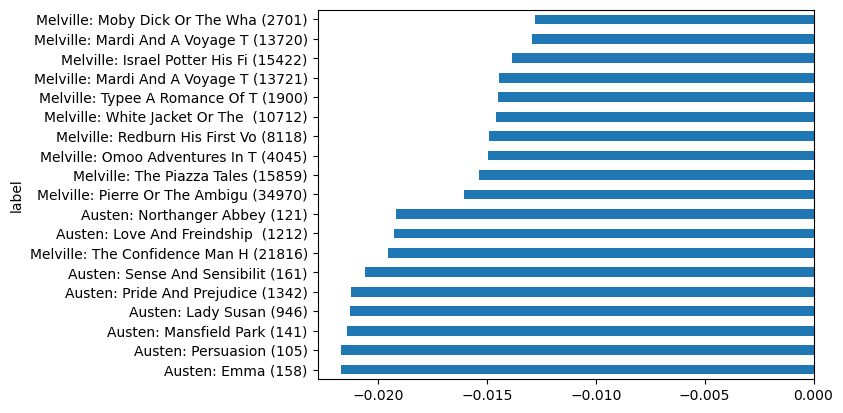

In [ ]:
BOOKS.join(LIB.label).set_index('label').mean(1).sort_values().plot.barh();

In [ ]:
import sys
sys.path.append(local_lib)

In [ ]:
from hac2 import HAC

<Figure size 640x480 with 0 Axes>

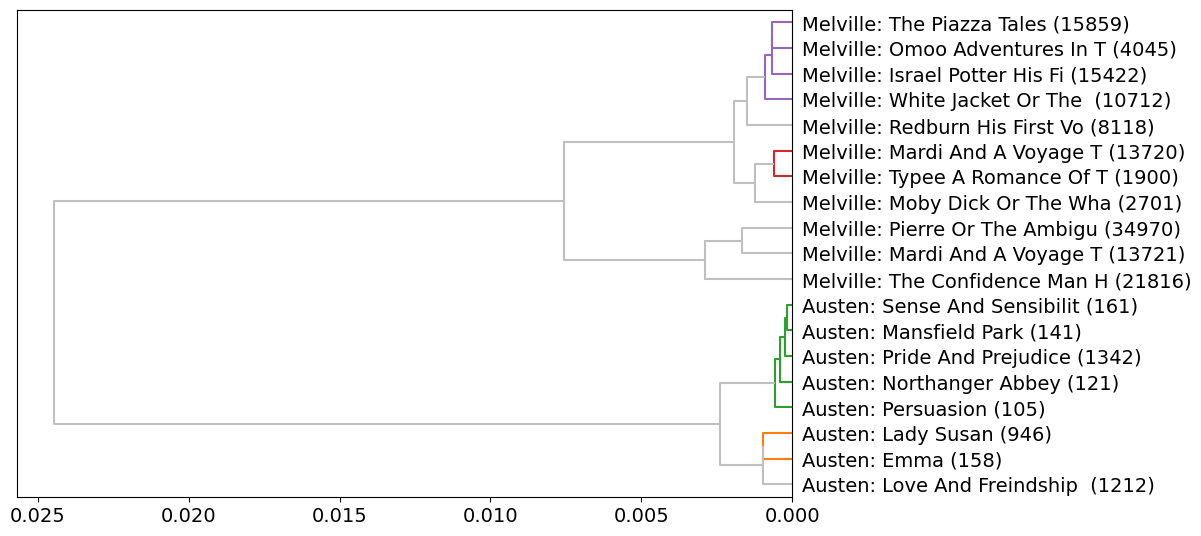

In [ ]:
HAC(BOOKS, labels=BOOKS.join(LIB.label, how='left').label.to_list()).plot()